# Import Packages

In [1]:
import sys
sys.path.append('..')

import matplotlib.pyplot as plt
import utils
import pandas as pd
import numpy as np
import math
import random
from isoweek import Week
import lightgbm as lgb
import pickle
from sklearn.metrics import mean_squared_error
from IPython.display import clear_output
from tqdm.notebook import tqdm
from croston import croston

# Settings

In [2]:
forecast_horizon = 1
path_models = utils.get_project_root() + '/03_Forecasting_LightGBM/models/'
target_variable = 'Turnover' # Either 'Turnover' or 'Sales_QTY'
n_splits = 4 # Number of cross validation splits

# Import Data

In [ ]:
query = 'SELECT * FROM `globus-datahub-dev.Verteiler_PoC.timeseries_sales_weekly` where Year >= 2015 and (Year <= 2019 OR (Year = 2020 AND Week <= 47))  order by sku, site_id, year, week'
df_raw = utils.bq_to_dataframe(
    query, verbose=True).pipe(utils.reduce_memory_usage)

In [ ]:
df = df_raw.copy()
df

# Preprocess Data

In [ ]:
# Get rid of negative Sales / Turnover
df.loc[:, 'Sales_QTY'] = df.Sales_QTY.clip(lower=0)
df.loc[:, 'Turnover'] = df.Turnover.clip(lower=0)

# Replace Censhare Cat if not applicable
df.loc[df.CENSHARE_CAT_1.isna(), 'CENSHARE_CAT_1'] = 'NA'

# Classify Data

Current Classification (A: Top-Seller, B: Medium-Seller, C: Low-Seller)

A:
At least one in 6 different weeks & mean sales per week greater 0.3

B:
At least one in 6 different weeks & mean sales per week greater 0.1

C:
All the rest


In [ ]:
df['Classification'] = 'C'

for i, g in df.groupby(['Site_ID', 'SKU']):
    
    if  (g.Sales_QTY[g.Sales_QTY > 0].count() > 5) & (g.Sales_QTY[g.Sales_QTY > 0].count() / g.Sales_QTY.count() > 0.4):
        df.iloc[list(g.index), df.columns.get_loc('Classification')] = 'A'
        
    elif (g.Sales_QTY[g.Sales_QTY > 0].count() > 5) & (g.Sales_QTY[g.Sales_QTY > 0].count() / g.Sales_QTY.count() > 0.1):
        df.iloc[list(g.index), df.columns.get_loc('Classification')] = 'B'

        
# Print summary: number of Time-Series per Classification
df[['Site_ID', 'SKU', 'Classification']].drop_duplicates()[['Classification']].value_counts()

# Plot Time Series

In [5]:
n_series = 8

In [6]:
def plot_timeseries(samples: int, sales: pd.core.frame.DataFrame) -> None:
    """
    Vizualize certain timeseries.
    :param: samples: list of lists with Site ID - Article combinations to be vizualized.
            Example: [['g590', 1282277826], ['g115', 1254150002], ['g102', 1264627019]]
    :param: sales: DataFrame containing the sales data (columns SKU, Site_ID & Year_Week required)
    :return None
    """
    fig, axs = plt.subplots(math.ceil(n_series / 2), 2, figsize=(15, n_series * 1.5))
    axs = axs.flatten()
    ax_idx = 0

    for site, article in samples:
        df_article = sales.loc[df.SKU == article].loc[df.Site_ID == site].sort_values(by='Date').reset_index()

        df_article.plot(x='Date',
                     y='Sales_QTY',
                     title= f'SKU: {article}, Site ID: {site}',
                     ax=axs[ax_idx])
        ax_idx += 1

    plt.tight_layout()
    plt.show()

## Class A (Top Seller)

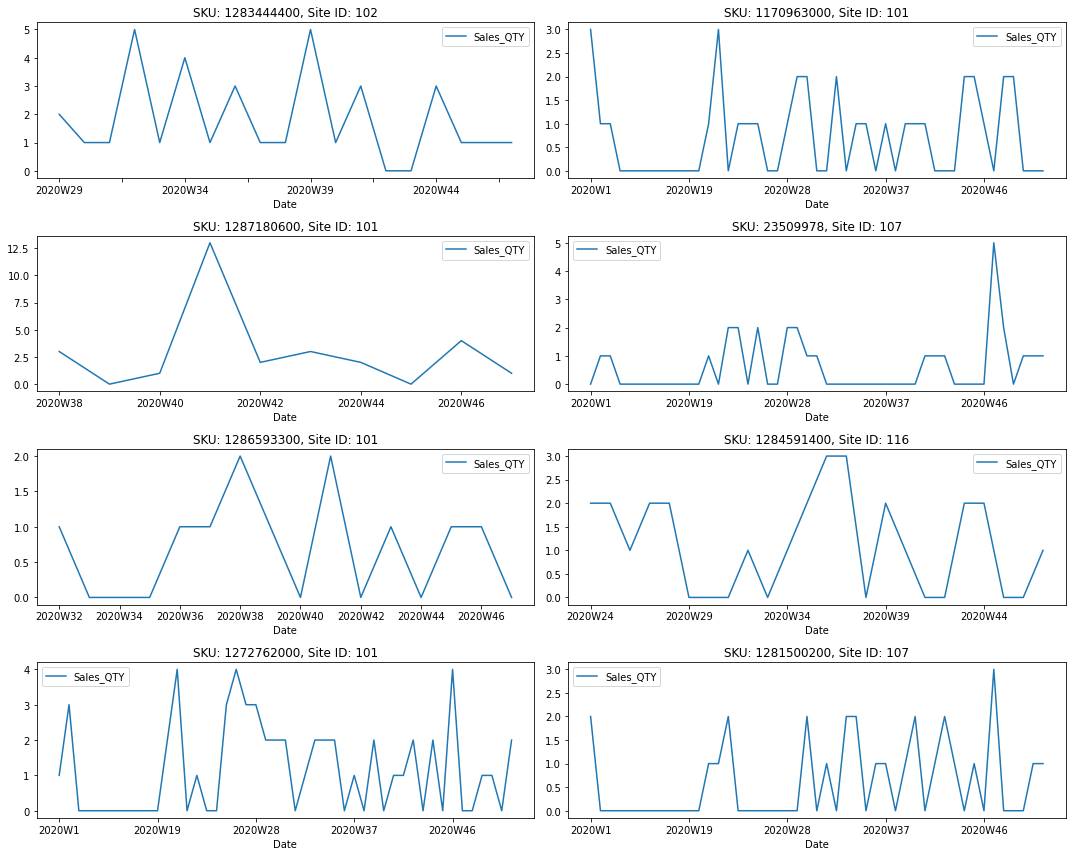

In [7]:
classification = 'A'
samples = df.loc[df.Classification == classification][['Site_ID','SKU']].drop_duplicates().sample(n=n_series, random_state=4).values.tolist()
plot_timeseries(samples, df)

## Class B (Medium Seller)

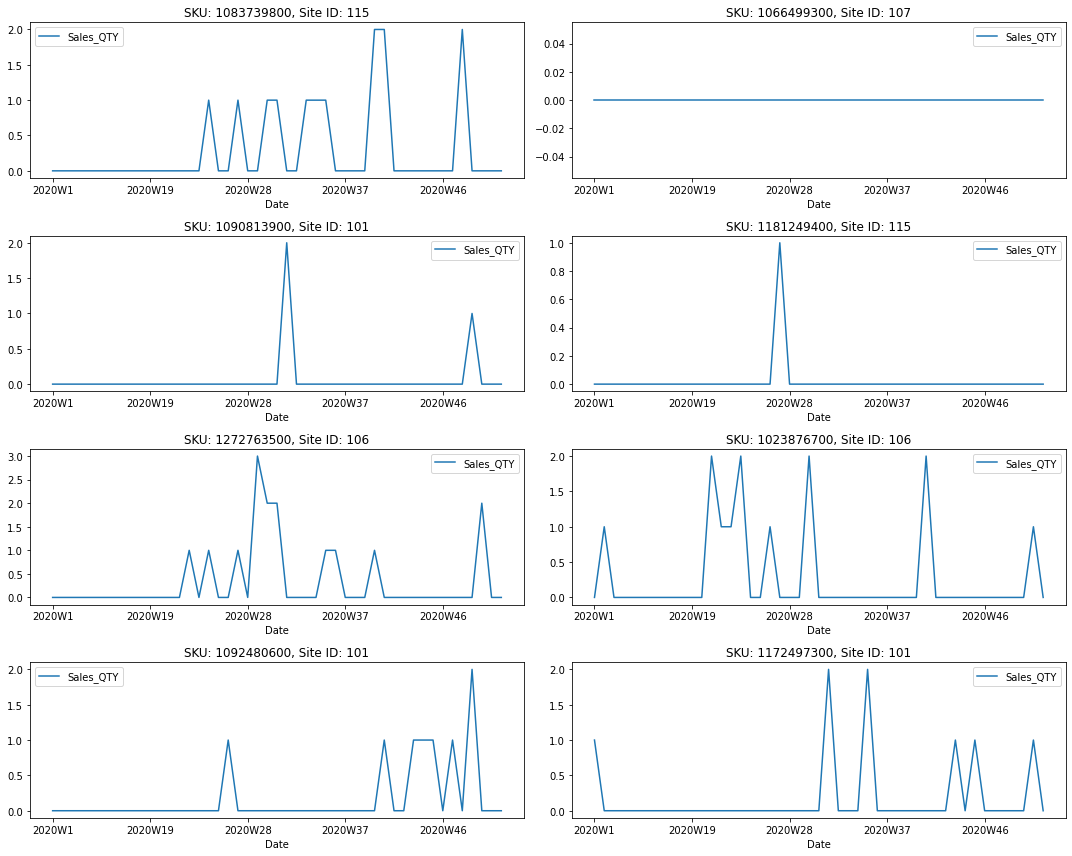

In [8]:
classification = 'B'
samples = df.loc[df.Classification == classification][['Site_ID','SKU']].drop_duplicates().sample(n=n_series, random_state=4).values.tolist()
plot_timeseries(samples, df)

## Class C (Low Seller)

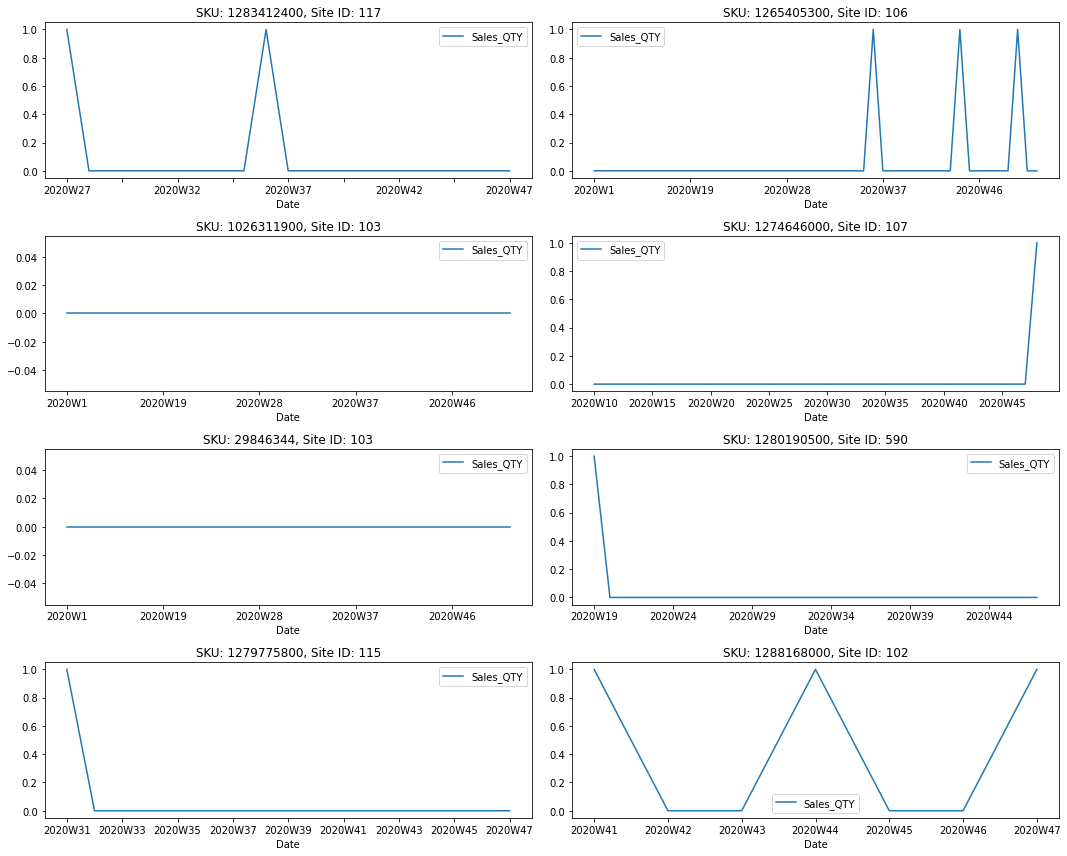

In [9]:
classification = 'C'
samples = df.loc[df.Classification == classification][['Site_ID','SKU']].drop_duplicates().sample(n=n_series, random_state=4).values.tolist()
plot_timeseries(samples, df)

# Forecasting

In [10]:
splits = utils.get_splits(df, fh=forecast_horizon, n_splits=n_splits)

In [11]:
def run_croston(ts_list: list,fh: int) -> list:
    """
    Forecast timeseries using Croson's Method.
    :param ts_list: timeseries to be forecasted (list)
    :param fh: forecast horizon (int)
    :return: predicted value without historacal timeries (list)
    """
    fit_pred = croston.fit_croston(ts_list, fh)
    return list(fit_pred['croston_forecast'])

In [12]:

# Preventing croston from printing https://www.codegrepper.com/code-examples/python/python+turn+off+printing
import os, sys
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')
        
    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

## Class A (Top Seller)

In [13]:
# Store RMSE values in list and validate at the end
rmse_overall = []
rmse_per_class = {"A": [], "B": [], "C": []}

# Store results in dataframe and validate the error at the end.
result_df = pd.DataFrame(columns=['Week', 'Year', 'Site_ID', 'SKU','Prediction']+[target_variable])


for week, year in tqdm(splits, desc='n Cross-Validation Split'):

    for article_classification in tqdm(['A', 'B', 'C'], desc='Article Classification'):

        result_classification = pd.DataFrame(
            columns=['Week', 'Year', 'Site_ID', 'SKU', 'Prediction'] + [target_variable])

        df_class = df.loc[df.Classification == article_classification].copy()
        
        if df_class.empty:
            continue

        week = int(week)
        year = int(year)

        # Prepare data
        df_train = df_class.loc[
            ((df_class.Year == (Week(year, week))[0]) & (df_class.Week <= (Week(year, week))[1])) | (
                        df_class.Year < (Week(year, week))[0])]
        targets = \
        df_class.loc[df_class.Year == (Week(year, week) + 1)[0]].loc[df_class.Week == (Week(year, week) + 1)[1]][
            ['Week', 'Year', 'SKU', 'Site_ID', 'Date'] + [target_variable]]

        # Forecast
        for i, sku_df in tqdm(df_train.groupby(['Site_ID', 'SKU']), desc='Timeseries'):
            with HiddenPrints(): 
                try:
                    yhat = run_croston(sku_df[target_variable].to_list(), 1)
                except:
                    yhat = [0]

            result_sku = pd.DataFrame({"Week": [(Week(year, week) + 1)[1]], "Year": [(Week(year, week) + 1)[0]],
                            "Site_ID": [sku_df.Site_ID.values[0]], "SKU": [sku_df.SKU.values[0]],
                            "Prediction": [yhat[0]],
                            target_variable: [targets.loc[targets.SKU == sku_df.SKU.values[0]].loc[targets.Site_ID == sku_df.Site_ID.values[0]][target_variable].values[0]]
                })

            # Append results of this category to classification DataFrame as well as overall DataFrame
            result_classification = result_classification.append(result_sku)
            result_df = result_df.append(result_sku)


        rmse_per_class[article_classification].append(
            mean_squared_error(result_classification.Prediction, result_classification[target_variable], squared=False))

    rmse_overall.append(mean_squared_error(result_df.Prediction, result_df[target_variable], squared=False))

clear_output()

In [14]:
# Print results
print('Overall RMSE:\n', rmse_overall)
print('\nMean Overall RMSE: ', np.mean(rmse_overall))


# Print results
print('Per Class RMSE RMSE:\n', rmse_per_class)

Overall RMSE:
 [84.98023308508648, 79.8187886633735, 76.18289205703853, 75.55459240627646]

Mean Overall RMSE:  79.13412655294374
Per Class RMSE RMSE:
 {'A': [80.05004296376025, 71.25721713573047, 69.64392623581581, 80.60679106763571], 'B': [75.5436678763449, 64.97862997943898, 65.47562808645198, 69.37333151318145], 'C': [91.51183139011341, 80.4174231056645, 69.80861533449324, 75.17394481355578]}


In [15]:
# Print results
print('Overall RMSE:\n', rmse_overall)
print('\nMean Overall RMSE: ', np.mean(rmse_overall))


# Print results
print('Per Class RMSE RMSE:\n', rmse_per_class)

Overall RMSE:
 [84.98023308508648, 79.8187886633735, 76.18289205703853, 75.55459240627646]

Mean Overall RMSE:  79.13412655294374
Per Class RMSE RMSE:
 {'A': [80.05004296376025, 71.25721713573047, 69.64392623581581, 80.60679106763571], 'B': [75.5436678763449, 64.97862997943898, 65.47562808645198, 69.37333151318145], 'C': [91.51183139011341, 80.4174231056645, 69.80861533449324, 75.17394481355578]}


In [16]:
result_df

,Week,Year,Site_ID,SKU,Prediction,Turnover
0,47,2020,101,1014557,15.549407,29.9
0,47,2020,101,1014824,8.446154,0.0
0,47,2020,101,1016525,94.134562,0.0
0,47,2020,101,1016800,46.762760,46.9
0,47,2020,101,1017246,20.729998,22.5
...,...,...,...,...,...,...
0,44,2020,590,1288237700,0.000000,17.7
0,44,2020,590,1288237800,0.000000,13.8
0,44,2020,590,1288237900,0.000000,37.9
0,44,2020,590,1288341800,0.000000,0.0
